In [2]:
from models.model_v3 import *
from utils.dataset_loader import *
from utils.testing_model import *
import pretty_midi

pygame 2.6.1 (SDL 2.28.4, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Setup

In [3]:
# Define the dataset.
DATA_FILE_PATH = "data/preprocessed/maestro-v3.0.0/dataset3/40K_dataset.h5"
dataset = MaestroV3DataSet(DATA_FILE_PATH, "triplet")

# Load model from checkpoint.
ckp_path = "./outputs/checkpoints/version_690_model_v3_first_good/checkpoints/fa_classifier_epoch=49.ckpt"
model = GAN.load_from_checkpoint(ckp_path)

In [4]:
# Major chords first notes (starts from C = 1th note)
MAJOR_CHORDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# Minor chords first notes (starts from A = 10th note)
MINOR_CHORDS = [9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8]


MAJOR_CHORD_NOTE_TRIPLETS = [
    [0, 4, 7],    # C Major (Tonic 0)
    [1, 5, 8],    # C# Major (Tonic 1)
    [2, 6, 9],    # D Major (Tonic 2)
    [3, 7, 10],   # D# Major (Tonic 3)
    [4, 8, 11],   # E Major (Tonic 4)
    [5, 9, 0],    # F Major (Tonic 5)
    [6, 10, 1],   # F# Major (Tonic 6)
    [7, 11, 2],   # G Major (Tonic 7)
    [8, 0, 3],    # G# Major (Tonic 8)
    [9, 1, 4],    # A Major (Tonic 9)
    [10, 2, 5],   # A# Major (Tonic 10)
    [11, 3, 6]    # B Major (Tonic 11)
]

MINOR_CHORD_NOTE_TRIPLETS = [
    [9, 0, 4],    # A Minor (Tonic 9)
    [10, 1, 5],   # A# Minor (Tonic 10)
    [11, 2, 6],   # B Minor (Tonic 11)
    [0, 3, 7],    # C Minor (Tonic 0)
    [1, 4, 8],    # C# Minor (Tonic 1)
    [2, 5, 9],    # D Minor (Tonic 2)
    [3, 6, 10],   # D# Minor (Tonic 3)
    [4, 7, 11],   # E Minor (Tonic 4)
    [5, 8, 0],    # F Minor (Tonic 5)
    [6, 9, 1],    # F# Minor (Tonic 6)
    [7, 10, 2],   # G Minor (Tonic 7)
    [8, 11, 3]    # G# Minor (Tonic 8)
]


In [5]:
# Function to insert a Basic pattern chords 
def pattern_chords_1(bars, selected_chord, offset, n_bars):
    for elem,b in enumerate(bars):
                #print(b.shape[2] - 1 - offset - 12)
                #print(b.shape[2] - 1 - offset)
                
                if elem < n_bars:
                    # row minor
                    for i in range(offset, 12 + offset, 1):
                        for j in range(b.shape[3] - 1):
                            #print(i)
                            #print(selected_chord[0],selected_chord[1], selected_chord[2])
                            if i == selected_chord[0] + offset or i == selected_chord[1] + offset or i == selected_chord[2] + offset:
                                b[0,0,i,j] = 0.2




In [6]:
# Function to decoding the chords emmbedded in the output tensor generated by the network
def decoding_chord(bars, chord_0):
    index = -1
     # Major chord
    if chord_0[0,12,0,0] == 0:
        print("Major chords")
        encoded_chord = np.where(chord_0 == 1)

        if encoded_chord[0].size > 0:
            index = encoded_chord[1][0]
        
        selected_chord = MAJOR_CHORD_NOTE_TRIPLETS[index]
        # To select the octave of the chord
        offset = 4
        offset = offset * 12
        
        pattern_chords_1(bars, selected_chord, offset, 7)

    # Minor chord
    elif chord_0[0,12,0,0] == 1:
        print("Minors chords")
        encoded_chord = np.where(chord_0 == 1)

        if encoded_chord[0].size > 0:
            index = encoded_chord[1][0]
        
        selected_chord = MINOR_CHORD_NOTE_TRIPLETS[index]
        # To select the octave of the chord
        offset = 4
        offset = offset * 12

        pattern_chords_1(bars,selected_chord,offset, 7)
    
    

In [7]:
 # Convert bars in numpy array.
def bars_to_piano_roll(bars, verbose):
    # Convert bars in numpy array.
    bars_numpy = []
    for bar in bars:
        bar = bar.squeeze(0, 1).detach().numpy()
        bars_numpy.append(bar)

    # Create the full piano roll.
    full_piano_roll = np.hstack([bar for bar in bars_numpy])
    if verbose:
        print("Full piano roll")
        print("Shape:", full_piano_roll.shape)
        show_piano_roll(full_piano_roll)

    # Multiply by 50.
    full_piano_roll *= 50

    # Create midi file.
    pm = piano_roll_to_pretty_midi(full_piano_roll, fs=8)
    return pm

In [8]:

# Generate a melody that in future processing can be accompanied with chords
def generate_melody_v3(model, n_bars, dataset, verbose=False):
# Set model in evaluation.
    model.eval()
    model = model.cpu()

    # Generate noise.
    noise = torch.randn(7, 1, 100)

    # Random index.
    rnd_idx = random.randint(0, len(dataset)-1)

    # Choose the first random sample from the dataset.
    bar_0, _ , _ = dataset[rnd_idx] # [1, 128, 16]
    bar_0 = bar_0.unsqueeze(0)  # [1, 1, 128, 16]

    _ , _ , chord_0 = dataset[rnd_idx] # [13 , 1, 1]
    chord_0 = chord_0.unsqueeze(0) # [1, 13 , 1 , 1] 

    # Generate 8 bar.
    bars = [bar_0]
    for i , z in enumerate(noise):
        # Previous bar.
        prev = bars[i]

        # Create the triplet.
        x = z, prev, chord_0

        # Generate current bar.
        curr = model(x)

        # Save genjerated bar
        bars.append(curr)

    # Processing to add in a specific way the coding of the chord for each bar
    #chord_0 = torch.zeros((1,13,1,1), dtype=int)
    #chord_0[0,1,0,0] = 1

    pm = bars_to_piano_roll(bars,verbose)

    return pm, bars, chord_0

    # for i in range(b.shape[2] - 1 - offset, b.shape[2] - 1 - offset - 12, -1):
    #     for j in range(b.shape[3] - 1 - 8):
    #         print(i)
    #         print(selected_chord[0],selected_chord[1], selected_chord[2])
    #         if i - comparison_offset == selected_chord[0] or i - comparison_offset == selected_chord[1] or i - comparison_offset == selected_chord[2]:
    #             
    #             b[0,0,i,j] = 0.6


## Generate melody

Full piano roll
Shape: (128, 128)


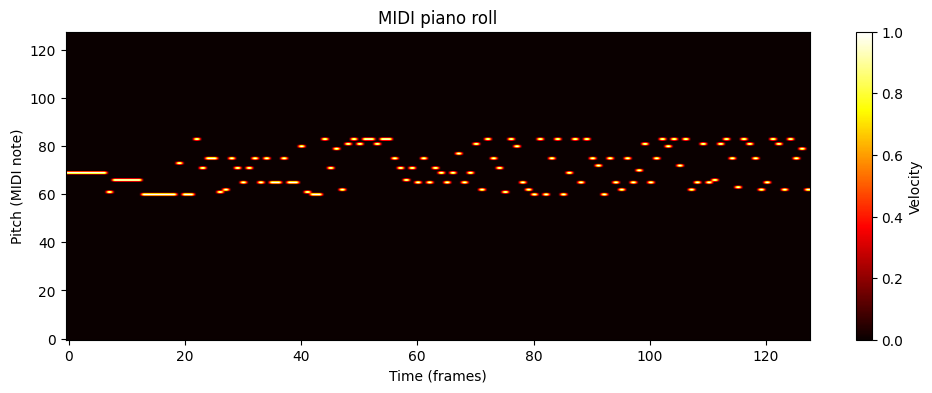

In [9]:
melody_pm_tryal, bars, chord_0 = generate_melody_v3(model, n_bars=8, dataset=dataset, verbose=True)


## Play generated melody with pygame

In [10]:
# Create the output midi file.
output_fn = "output_test.midi"
melody_pm_tryal.write(output_fn)

In [11]:
reproduce_midi("output_test.midi")

🎵 Reproduction of'output_test.midi'...
Reproduction ended.


## Choosing The chord pattern accompaniment based on chord_0


Minors chords
Full piano roll
Shape: (128, 128)


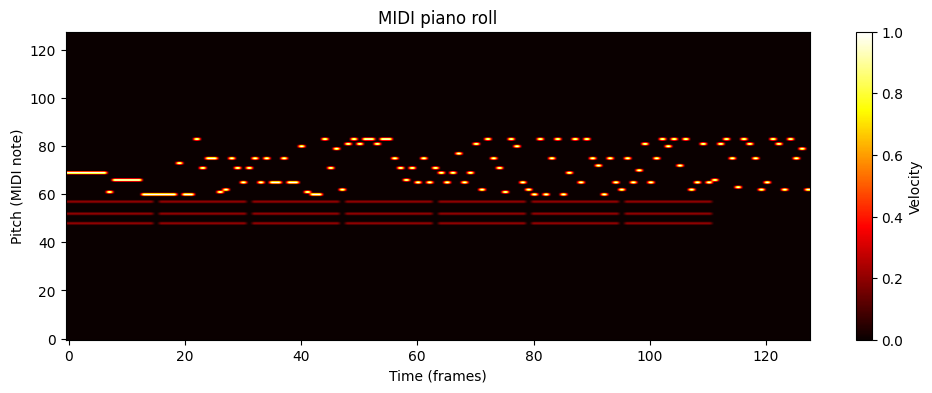

In [12]:
decoding_chord(bars, chord_0)
melody_pm = bars_to_piano_roll(bars, True)




# Create the output midi file.
output_fn = "output_test.midi"
melody_pm.write(output_fn)



In [111]:
reproduce_midi("output_test.midi")

🎵 Reproduction of'output_test.midi'...
Reproduction ended.
